In [1]:
import os
import zipfile

def zip_folder(folder_path, output_zip):
    """
    Zip the contents of an entire folder (with that folder included
    in the archive). Empty directories are included in the archive as well.
    """
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        lenDirPath = len(folder_path)
        for root, _, files in os.walk(folder_path):
            # Include all subdirectories, including empty ones.
            for dirName in os.listdir(root):
                dirPath = os.path.join(root, dirName)
                if os.path.isdir(dirPath):
                    zipf.write(dirPath, os.path.relpath(dirPath, folder_path))
            # Add files
            for file in files:
                filePath = os.path.join(root, file)
                zipf.write(filePath, os.path.relpath(filePath, folder_path))

In [2]:
zip_folder("/kaggle/input/isig-wheels/iisignature-0.24", "./isig.zip")

!pip install "./isig.zip"

Processing ./isig.zip
  Preparing metadata (setup.py) ... - \ done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=1401821 sha256=60bdca295993ccba9ae6f24e5c1e38718eb07e0f3de17ed04ccbbce5e4604c85
  Stored in directory: /tmp/pip-ephem-wheel-cache-ub3c8zpg/wheels/1e/cc/c1/df8da0c28148d0b5dd2ba81acb40a50cda02da4b95bba89080
Successfully built iisignature


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import iisignature as isig
from basic_preprocessing_utility_script import process_as_h5, signature, get_eeg_sp_data

iisignature is already installed.


# Build/ Train Model

Load signature features and prepare for training NN

In [4]:
def TrainPreProcessing(DataPortion, Validation_Split=None):
    
    # Load all numpy arrays 
    EEG_Sig_Total = np.load('/kaggle/input/post-sig-trans/EEG_Sig_Total.npy')    
    
    NumVotes_Total = np.load('/kaggle/input/post-sig-trans/NumVotes_Total.npy')
    Targets_Total = np.load('/kaggle/input/post-sig-trans/Targets_Total.npy')

    
    # Combine columns into one array: ¦1390 Features¦6 Targets¦NumVotes¦ 
    TotalDataset = np.hstack((EEG_Sig_Total, Targets_Total, NumVotes_Total))
    
    # We want to drop all rows with nans in them
    nan_rows = np.isnan(TotalDataset).any(axis=1)
    # Drop rows with NaN values
    TotalDataset = TotalDataset[~nan_rows]
    
    TotalN = TotalDataset.shape[0]


    # shuffle rows
    np.random.seed(69)
    p = np.random.permutation(TotalN)

    TotalDataset = TotalDataset[p]

    # Work with only a small portion of the dataset for experimentation 
    N = round(DataPortion*TotalN)

    TruncatedDataset = TotalDataset[:N]
    
    if not(Validation_Split is None):       

        # set proportion of train data for validation set
        Validation_N = round(Validation_Split*N)

        ValidationDataset = TruncatedDataset[:Validation_N]
        TrainDataset = TruncatedDataset[Validation_N:]
        
        X_val, y_val = ValidationDataset[:,:1390], ValidationDataset[:,1390:1396]
        X_train, y_train = TrainDataset[:,:1390], TrainDataset[:,1390:1396]
        N_votes_train = TrainDataset[:,-1]
        
        return X_train, y_train, X_val, y_val, N_votes_train

        
    else:
        TrainDataset = TruncatedDataset
        X_train, y_train = TrainDataset[:,:1390], TrainDataset[:,1390:1396]
        N_votes_train = TrainDataset[:,-1]
        
        return X_train, y_train, N_votes_train

In [5]:
# Do not need a test set from the train data since we are submitting
X_train, y_train, X_test, y_test, N_votes_train = TrainPreProcessing(DataPortion=1, Validation_Split=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(106789, 1390) (106789, 6)
(0, 1390) (0, 6)


Build NN

In [6]:
import tensorflow as tf
import random
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import kullback_leibler_divergence
from tensorflow.keras.callbacks import EarlyStopping


# Define the number of input features and output classes
num_features = 1390
num_classes = 6

2024-03-31 04:57:07.428685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 04:57:07.428819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 04:57:07.577018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Set random seeds for reproducibility
seed_value = 69

# 1. Set the seed for Python's built-in random number generator
random.seed(seed_value)
# 2. Set the seed for NumPy
np.random.seed(seed_value)
# 3. Set the seed for TensorFlow
tf.random.set_seed(seed_value)

# Performance on total train dataset w/ 10% portioned for test: 0.655



# Random attempt
def create_model():
    inputs = tf.keras.Input(shape=(num_features,))
    
    x = layers.Dense(800, activation='tanh')(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(600, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(150, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Instantiate the model
model = create_model()

# Compile the model with KL divergence loss
model.compile(optimizer='adam',
              loss=kullback_leibler_divergence)

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1390)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 800)            │     1,112,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 600)            │       480,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │       180,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,828,904 (6.98 MB)

 Trainable params: 1,828,904 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

Train

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, batch_size=500, epochs=1000, validation_split=0.05, callbacks=[early_stopping])

Epoch 1/1000
 30/203 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4631

I0000 00:00:1711861049.398685      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711861049.414966      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3243

W0000 00:00:1711861055.910515      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711861056.515368      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 1.3240 - val_loss: 1.1042
Epoch 2/1000
 28/203 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1502

W0000 00:00:1711861057.122906      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1334 - val_loss: 1.0134
Epoch 3/1000
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0597 - val_loss: 0.9592
Epoch 4/1000
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0064 - val_loss: 0.9151
Epoch 5/1000
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9706 - val_loss: 0.8828
Epoch 6/1000
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9460 - val_loss: 0.8630
Epoch 7/1000
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9167 - val_loss: 0.8434
Epoch 8/1000
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8956 - val_loss: 0.8322
Epoch 9/1000
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8786 - val_loss: 0.8122
Epoch 10/1000
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8645 - val_loss: 0.8038
Epoch 11/1000
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8519 - val_loss: 0.7959
Epoch 12/1000
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8397 - val_loss: 0.7831
Epoch 13/1000
203/203 ━━━━━━━━━━━━━━━━━━━━

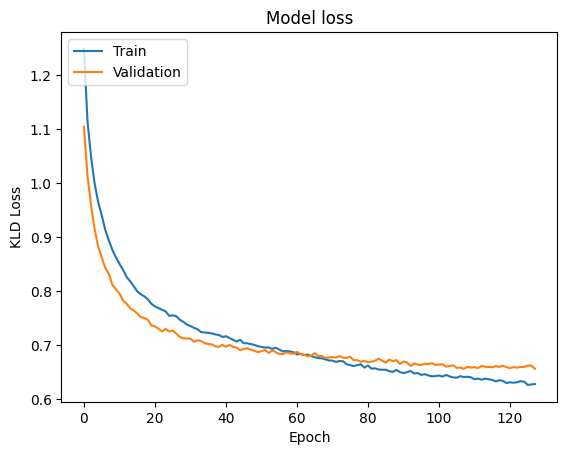

In [9]:
# Assuming 'history' contains the training history returned by model.fit()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('KLD Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Process and Predict on the Test set for submission

In [10]:
import pandas as pd

In [11]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape:',test.shape)

Test shape: (1, 3)


In [12]:
EEG_SUB_PATH_TEMPL = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
SP_SUB_PATH_TEMPL = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'

def get_sub_eeg_sp_data(train_row):
    """Gets EEG and Spectogram data from a specific row in the dataset"""
    
    eeg_id = train_row.eeg_id
    sp_id = train_row.spectrogram_id
    
    eeg_parquet = pd.read_parquet(f'{EEG_SUB_PATH_TEMPL}{eeg_id}.parquet')
    sp = pd.read_parquet(f'{SP_SUB_PATH_TEMPL}{sp_id}.parquet')
    
    rows = len(eeg_parquet)
    eeg_offset = (rows-10_000)//2
    
    
    # get middle 50 seconds of eeg data
    #eeg_offset = int(train_row.eeg_label_offset_seconds + 20) #only 10 central seconds from 50 secs were labeled, which should be seconds 20-30 in the sample
    eeg_data = eeg_parquet.iloc[eeg_offset:eeg_offset + 10_000]
    
    
    # sp_offset = int(train_row.spectrogram_label_offset_seconds )
    
    # get spectrogram data
    # sp = sp_parquet.loc[(sp_parquet.time>=sp_offset)&(sp_parquet.time<sp_offset+SP_WIN)]
    sp = sp.loc[:, sp.columns != 'time']
    sp = {
        "LL": sp.filter(regex='^LL', axis=1),
        "RL": sp.filter(regex='^RL', axis=1),
        "RP": sp.filter(regex='^RP', axis=1),
        "LP": sp.filter(regex='^LP', axis=1)}
    
    # calculate eeg data
    # print(eeg_data.keys()) # Has keys Index(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
                            # 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    # assert 0 == 1
    
    CHAINS = {
    'LL' : [("Fp1","F7"),("F7","T3"),("T3","T5"),("T5","O1")],
    'RL' : [("Fp2","F8"),("F8","T4"),("T4","T6"),("T6","O2")],
    'LP' : [("Fp1","F3"),("F3","C3"),("C3","P3"),("P3","O1")],
    'RP' : [("Fp2","F4"),("F4","C4"),("C4","P4"),("P4","O2")],
    'other' : [("Fz","Cz"), ("Cz", "Pz"), ("EKG")]
}
    
    eeg = pd.DataFrame({})
    for chain in CHAINS.keys():
        for s_i, signals in enumerate(CHAINS[chain]):
            if len(signals) == 2:
                diff=eeg_data[signals[0]]-eeg_data[signals[1]] # Subtracts relevant fields as in the image above
                diff.ffill(inplace = True) # forward fills in the casse of nan values
                eeg[f"{chain}: {signals[0]} - {signals[1]}"] = diff
            
            elif len(signals) == 1:
                sig=eeg_data[signals[0]]
                sig.ffill(inplace = True) 
                eeg[f"{chain}: {signals[0]}"] = sig
                
                
    
    return eeg, sp

def preprocess(pre_eeg):
    pre_eeg_streams = [pre_eeg[:,:,:4],  pre_eeg[:,:,4:8], pre_eeg[:,:,8:12],
                       pre_eeg[:,:,12:16], pre_eeg[:,:,16:]]
    
    pre_eeg_stream_sig = [signature(stream, level=4) for stream in pre_eeg_streams]
    pre_eeg_sig = np.concatenate(pre_eeg_stream_sig, axis=-1)
    
    return pre_eeg_sig
    
    

In [13]:
eeg_sub, sp_sub = get_sub_eeg_sp_data(test.iloc[0])

eeg_sub = np.expand_dims(eeg_sub, axis=0)
prep_eeg_sub = preprocess(eeg_sub)

print(prep_eeg_sub.shape)

(1, 1390)


In [14]:
sub_pred = model.predict(prep_eeg_sub)

print("This is the sub pred sum:",sub_pred.sum())
print(sub_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
This is the sub pred sum: 1.0000001
[[0.25551298 0.05086019 0.09536818 0.09401198 0.31282127 0.19142546]]


In [15]:
# CREATE SUBMISSION.CSV
from IPython.display import display

sub = pd.DataFrame({'eeg_id':test.eeg_id.values})

TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
sub[TARGETS] = sub_pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
display( sub.head() )

# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
print('Sub row 0 sums to:',sub.iloc[0,-6:].sum())

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.255513,0.05086,0.095368,0.094012,0.312821,0.191425


Sub row 0 sums to: 1.000000063329935
